* http://johncbogle.com/wordpress/data/
* https://coin.dance/stats/marketcaphistorical
* https://etherscan.io/chart/marketcap
* https://ycharts.com/indicators/ethereum_market_cap

In [1]:
#!pip install python-coinmarketcap

In [2]:
from coinmarketcapapi import CoinMarketCapAPI, CoinMarketCapAPIError

API_KEY = 'a6fc74d7-5522-4c15-8e90-afb2555f7b4f'
cmc = CoinMarketCapAPI(API_KEY)
r = cmc.cryptocurrency_info(symbol='BTC')


In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
START_DATE = '1916-01-01'

def convertDateArr(arr):
    return [convertDate(d) for d in arr]

def convertDate(val):
    d = val.split('-')
    d = [d[2],d[0],d[1]]    
    return '-'.join(d)

def stripCharacter(arr,c,r=''):
    return np.array([e.replace(c, r) for e in arr])

def str2Float(arr):   
    res = np.zeros(len(arr))
    for k in range(len(arr)):  
        try: 
            res[k] = float(arr[k]) 
        except: 
            res[k] = np.nan   
    return res

def annual_compound(arr, investment = 1):

    investment_arr = np.array([investment])
    for k in range(len(arr)-1):
        investment += investment*arr[k]/100
        investment_arr = np.append(investment_arr, investment) 
        
    return investment_arr 

def compound_return(rebase, freq=12, deposit=1):
    return deposit*(1+rebase/100)**(freq)

def rebase2Apy(rebase,f):
    x = (rebase/100+1)**f
    return x2Percent(x)

def x2Percent(x):
    return 100*(x - 1)

def str2Date(arr):
    return np.array([datetime.datetime.strptime(d, "%Y-%m-%d") for d in arr])

def getDate(t, strt_date = START_DATE):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d") + datetime.timedelta(days=365.25*t) 


### Crypto Market Share

In [5]:
stock_returns = pd.read_csv('../resources/stock_returns.csv')
btc_marketcap = pd.read_csv('../resources/btc_marketcap.csv')
eth_marketcap = pd.read_csv('../resources/eth_marketcap.csv')

eth_marketcap.columns = ['date','unixtimestamp','supply','eth_mc','price']
btc_marketcap.columns = ['date','alt_mc','btc_mc']


In [6]:
eth_marketcap.drop(['supply', 'price', 'unixtimestamp'], axis=1, inplace=True)
arr = eth_marketcap['date'].values
arr = stripCharacter(arr,'/',r='-')
arr = convertDateArr(arr)
arr = str2Date(arr)
eth_marketcap['date'] = arr
eth_marketcap['eth_mc'] = 1e6*eth_marketcap['eth_mc'].values

arr = btc_marketcap['date'].values
btc_marketcap['date'] = str2Date(arr)

In [7]:
crypto_marketcap = btc_marketcap.merge(eth_marketcap, how='left')
tot_mc = crypto_marketcap['btc_mc'].values + crypto_marketcap['alt_mc'].values
crypto_marketcap = crypto_marketcap.assign(tot_mc = tot_mc)
crypto_marketcap.tail(3)

,date,alt_mc,btc_mc,eth_mc,tot_mc
2159,2022-01-23,9.052421e+11,6.669604e+11,3.031738e+11,1.572202e+12
2160,2022-01-24,8.924502e+11,6.796581e+11,2.913585e+11,1.572108e+12
2161,2022-01-25,9.208987e+11,6.985582e+11,2.934653e+11,1.619457e+12


In [8]:
btc_dom = crypto_marketcap['btc_mc'].values/crypto_marketcap['tot_mc'].values 
eth_dom = crypto_marketcap['eth_mc'].values/crypto_marketcap['tot_mc'].values 

crypto_marketcap['btc_dom'] = btc_dom
crypto_marketcap['eth_dom'] = eth_dom


In [25]:
from scipy.stats import kendalltau, pearsonr, spearmanr
kendalltau(btc_dom, eth_dom)

KendalltauResult(correlation=-0.6701581864359402, pvalue=0.0)

In [23]:
np.corrcoef(btc_dom,eth_dom)[1,0]

-0.828633062628796

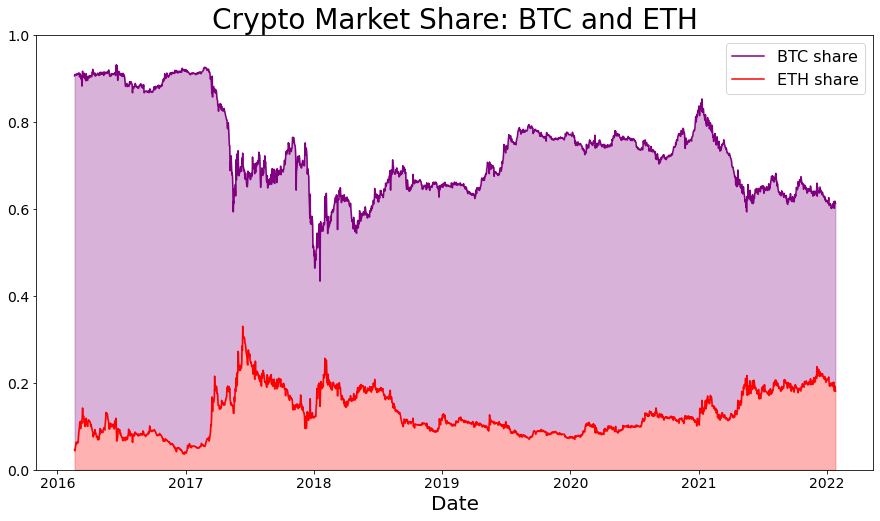

In [14]:
colors = ['purple','red','grey','green','blue']

dates = crypto_marketcap['date'].values
bot = np.zeros(len(dates))

fig = plt.figure(figsize=(15, 8))
plt.plot(dates, btc_dom+eth_dom, label='BTC share',color=colors[0])      
plt.fill_between(dates, eth_dom, btc_dom+eth_dom, alpha=0.3, color=colors[0])
plt.plot(dates, eth_dom, label='ETH share',color=colors[1])
plt.fill_between(dates, bot, eth_dom, alpha=0.3, color=colors[1])
plt.title("Crypto Market Share: BTC and ETH", fontsize=28)
plt.xlabel("Date", fontsize=20)
plt.ylim(bottom=0,top=1)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.legend(fontsize=16)

fig.savefig('../img/market_cap.png')


### S&P Index 

In [10]:
dates = [getDate(t) for t in range(len(stock_returns))]

for colnm in stock_returns.columns[1:]:
    arr = stock_returns[colnm].values
    arr = str2Float(arr)
    stock_returns[colnm] = arr

In [11]:
return_stocks_arr = stock_returns['actual_total_return'].values
stocks_arr = annual_compound(return_stocks_arr, investment = 1)  

return_bonds_arr = stock_returns['return_bonds'].values
bonds_arr = annual_compound(return_bonds_arr, investment = 1)

return_60_40_arr = 0.6*return_stocks_arr + 0.4*return_bonds_arr
sixty_forty_arr = annual_compound(return_60_40_arr, investment = 1)

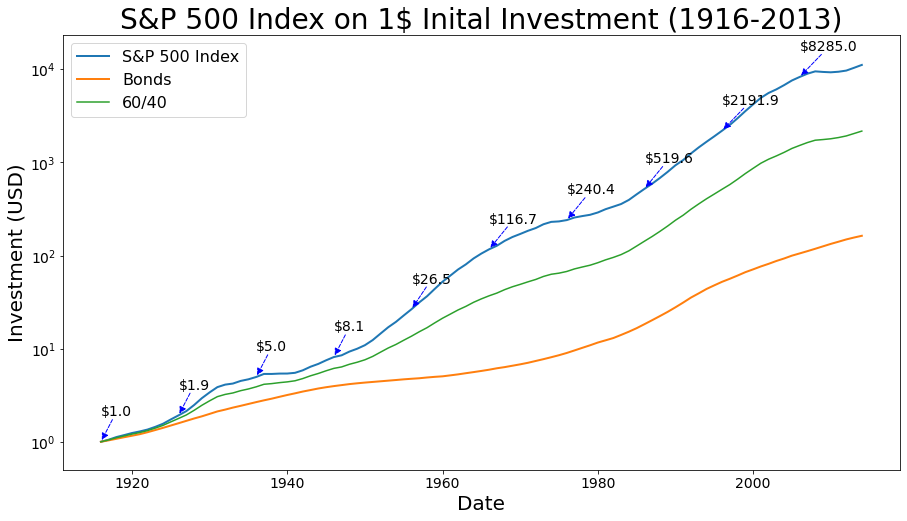

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.yscale('log', subs=[1])
plt.plot(dates, stocks_arr, label='S&P 500 Index', linewidth=2)
plt.plot(dates, bonds_arr, label='Bonds', linewidth=2)
plt.plot(dates, sixty_forty_arr, label='60/40')
plt.title("S&P 500 Index on 1$ Inital Investment (1916-2013)", fontsize=28)
plt.ylabel("Investment (USD)", fontsize=20)
plt.xlabel("Date", fontsize=20)

for k in range(len(dates)):
    if (k % 10 == 0):

        y_set = 0.9*stocks_arr[k] + stocks_arr[k]
        plt.annotate('${:.1f}'.format(stocks_arr[k]), 
            xy=(dates[k],stocks_arr[k]), 
            xytext=(dates[k],y_set), arrowprops=dict(arrowstyle= '-|>', 
            color='blue', lw=1, ls='--'), bbox=dict(boxstyle='square,pad=-0.07', 
            fc='none', ec='none'), fontsize=14)

plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)        
plt.ylim(bottom=0.5,top=1.1*stocks_arr[k] + stocks_arr[k])
plt.legend(fontsize=16)

fig.savefig('../img/spx_index_invest.png')


In a previous article we spoke about a solution to create a decentralized financial computing system to serve Web 3.0 and subsequently on the different blockchain designs and why we feel like the modular blockchain design is the state-of-the-art in how we achieve scalability, decentralization and security at the same time.

We will now present our ideals applied to a desirable blockchain, one if we had a choice to choose the best of all worlds we would design it in such a way to be the most efficient way to achieve decentralized scalable consensus to serve a smart contract platform.

Verify-then-trust everything
The devil is in the details with differing designs for layer 1 blockchains, on one hand you have Bitcoin which uses a tried and tested decentralized model of every node checks everything and makes no tradeoffs of subset of nodes participating in special consensus and on the other hand you have chains with subsets of nodes acting under authorization kept honest by crypto-economics to honestly validate and provide optimizations to base layer performance.

availability

However can we honestly scale up and provide light-client security effectively for a smart chain if every node is to check everything? We argue that it is indeed possible if you incentivize full-nodes, achieve “ZK-SNARK everything”, align layer 1 economic incentives for finance using zero-knowledge proof systems such as zkRollups instead of using layer 1 and find ways to scale on data availability serving rollups without introducing shared costs to create a minimal viable consensus for a blockchain system that retains the trust and security model of Bitcoin but scales as a modular blockchain.

With the rapid development in the field of zero-knowledge proofs we have been able to see how we can optimize and increase performance in ways which do not require us to make these tradeoffs way from the complete decentralized model of verify-then-trust everything. Blockchains are responsible for two things to ensure security of funds, computational consensus and data availability. Computational consensus ensures that the ledger is in a consistent state by assuring any local node can recompute the balances of everyone to ensure no double-spends have occurred and data availability ensures you have the information needed to move funds on the blockchain. Since computational consensus can be replaced by zero-knowledge proofs we can focus on data availability as the next direction of research to create completely decentralized systems without the need to depend on supernodes or subsets. That is not to say subset of nodes cannot be useful (ie: for proof-of-service — see below). The assumption in Bitcoin is that at least 1 other node is available to synchronize with so that locally one can assure they are not only in the correct state but also communicate with the network safely. If one node is connected to another node which is connected to another and so on and they are all honest participants then you have what Bitcoin is and that is an altruistic model for participating in consensus but fully decentralized and no third-party dependence on security other than yourself. Deviating away from this idea could and will lead to disastrous consequences as it is placing trust, security and authorization of the network away from the model that has proven to work (miners race to form blocks and full nodes accept, reject) to something with untold vectors of gamification to create advantages to specific participants.

We would like to design systems that do not trade fundamental tenets of the design of chain which is the most decentralized, meaning every node checks everything and a miner mechanism design which is working under a game theory model expending real world resources as a base cost to create a value of work represented in the form of blocks, paid by fees and block subsidy.

The premise in this article is that any base layer blockchain design that deviates from these ideal tenets outlined will result in a degradation of security or hardness of output of coins resulting in less decentralization and likely more attack vectors from the result of black swan events. Although it may seem possible to do light-client or embedded device can quickly and efficiently synchronous to systems with PoS and sharding designs, they end up making tradeoffs making the overall system more susceptible to long-term effects of economic game-theory malfeasance. The result of such decisions will lead to a continuous set of hard forks to exit out of check-mate scenarios which will end up leading to a crisis of confidence in such systems.

As we touched on light-clients it is important to note that users do not need to download a full base-layer to have trust-less interaction with the modular design as they would likely be sitting on a layer 2 zkRollup where a simple and quick merkle proof can prove a user owns some balance in the system and a ZKP verification can guarantee the latest state of the rollup, light-clients can interact from scratch within milliseconds and under 100kb of bandwidth requirements.

EIP 1559
EIP-1559 is a promising way forward to create long-term economic benefits to a blockchain design geared towards serving utility through a Turing complete economy of contracts.

Applying it to our ideal design we can see an even bigger story at play. Not only does it allow us to achieve a Minimum Viable Inflation strategy but it allows us to achieve the most efficient way to secure our ledger while remaining essentially “green” by borrowing PoW from Bitcoin miners in a merged-mining mechanism, yet also provides incentives for full-nodes to run long-term without the worry that they will have to rely on fees to remain profitable. By relying on PoW in a verify-then-trust decentralized network we also create hardness of coins which are unequal to other forms of consensus as there is provable energy expended in the creation of the coins, we couple that with a validator strategy where the validators are essentially paid to run full-nodes. EIP-1559 enables all of this for us as a way to decouple deflation risks and manage them in a very efficient way by assigning a minimum inflation strategy to keep the network healthy and participants who are assigned to do work profitable long-term.

Minimum Viable Inflation

Every layer 1 chain needs to defend itself with a cost model in the form of a gas token which competes for block space and execution as well as data availability to serve modular architecture (see below for more on that — PoDA). In order to pay for this defence the consensus needs to:

1) Inflate money supply
2) Tax block space usage
3) Tax data availability assurances (again more on this below — PoDA)

If your inflation costs exceed your tax revenue you’re operating at a deficit. A deficit is not sustainable long-term. Either the token would need to appreciate or available block space would need to be restricted to achieve equilibrium/surplus in security. A sustainable layer 1 would be one which makes the block space and data availability assurance valuable. Making block space valuable would require demand for layer 1 block space which comes in the way of rollups and validity proofs as well as the odd executions from users on layer 1. Data availability assurances would come in the way of rollups requiring guarantees of data replication for volition models to scale up the zkRollup paradigm. This should remove the cost bottleneck of onchain data availability for rollups to the computing cost of creating the zero-knowledge proof which would lead to a decentralized cost model.

What is the minimum viable amount of inflation necessary to create a long-term sustainable platform? If we compare the extreme’s where we deflate to 0 and inflation becomes nothing, the cost of the token could end up prohibitively high creating an undesirable economy to use block space and availability. If we inflate too much we start operating in a deficit and security ends up suffering long-term.

In Syscoin we modelled out inflation based on natural growth of population to match long-term growth of demand in an ideal blockchain system where financial computing is used as a base-layer to power smart cities, IoT, DeFi, metaverse and all sorts of decentralized application paradigms.

** Figure **

As you can see we are at about a 1 percentage growth trajectory falling over time which is the same rate of emissions we have with Syscoin, this way we achieve stability as demand for using the system will perpetually grow along with the base population of users. This does not account for intelligent machines becoming users and we assume they will find more optimal usages of layer 1 real-estate by relying on layer 2 and only invoking layer 1 when necessary in their designs.

By giving a long-term inflation strategy which is the minimum amount based on growth of population we can achieve long-term equilibrium on the security defence of our ideal blockchain design. Paid full nodes (masternodes) and miners should be given long-term assurances of block subsidy. In a merged-mine model, Bitcoin miners as well may leverage this assurance as Bitcoin subsidy deflates towards being negligible.

Proof-of-service
Since we verify and trust everything we don’t have a consensus system that depends on a subset of nodes to provide the ultimate trust model in our ideal blockchain design. However for decentralization we should still have a profit model to incentivize long term nodes to run and keep the network sybil resistant. The creation of a Proof-of-service module serves as a foundation to build other required features in our ideal design such as MEV protection and finality but also specifically for the service creates a base-layer of liveness to be able to connect to a honest full node at any time. This is in contrast to altruistic assumptions like in Bitcoin and other decentralized networks where you have to assume at least 1 node you are connecting to is honest. However if you don’t rely on validators to stake to create proof-of-service how do you do it?

In Syscoin we used masternodes which require 100000 SYS to lock up as collateral and run a full-node in a configured mode as a masternode. The masternode confirms on the network and through a quorum mechanism there is an aggregate BLS signature formed to assure liveness through a Distributed Key Generation (DKG) process. If during the DKG process certain registered nodes do not respond with valid signatures, they are marked bad as they are not providing liveness and are rejected from participating as masternodes further, losing their block subsidies subsequently. Instead of negative or punitive economic alignment with these special nodes (which we do not feel is safe and desired by network participants) we instead let the network reserve the right to stop the masternode from participating which requires re-registration and waiting for another round to be paid. Quorums are established every 12 hours and so the idea is that masternodes not providing service will be caught during the DKG process.

Once we have a set of masternodes we create a base-level of network liveness which creates assurances of honest network policy being enforced and much harder for miners to disseminate bad information. This is additive in assurances on top of something like the Bitcoin network today.

Merged-mining Bitcoin for shared green security

** Figure **

Above is the basic idea of merged-mining with Bitcoin where the nonce is mined by Bitcoin miners and solves both the child chain but may not necessarily solve the Bitcoin difficulty target. There is much more to it but this is the basic idea, you would have to add the Bitcoin header into the child chain and some other things to prove authenticity of the work but at a core level this is it. You can see that the child chain does not need to verify the Bitcoin blockchain and adhere to its policy but can form its own rules.

However just naive merged-mining also has its problems as Luke Dash Jr. pointed out through a CoiledCoin attack in 2012. We need a way to prevent selfish-mining so that a pool with majority hash could not reject the work of minority part of the network and likely negate the attack’s usefulness. For this some sort of finality is required. One way Syscoin solved this was through the use of chainlocks, but any sort of super-majority voting consensus via validators done in a secure way can solve this. However it should be noted that in many cases if the validators are not bonded by hard money (expended resources) then it is not a secure strategy as during black-swan events there are windows of opportunity potentially for actors to benefit from being able to game the finality or potentially further disrupt validators that are responsible for the selfish-mining solution on a chain.

MEV protection
When introducing Turing completeness and ultimately Decentralized Finance there are externalities for revenue opportunities created that don’t exist in the Bitcoin model. For example miners can be bribed to re-organize a blockchain if there is a out-of-band trade available in the DeFi ecosystem that will pay more than the cost of re-organizing the chain, which affects the honest users which have their transactions potentially reverted. This is called MEV (Miner Extractable Value) and is a result of any blockchain that enables DeFi or out-of-band economics that an authorizing participant in the consensus can be coalesced with by tips/bribes or some sort of collusion. The complexities of MEV on the base layer are almost impossible to avoid in a DeFi settlement layer since even with privacy there may always be ways to detect economic anomalies to have miners participate in auctions to re-organize blocks. The only real way to solve this problem is to try to create some sort of finality on the chain that removes longer-term MEV attacks by capping the term of the attack to something manageable for a DeFi settlement layer. In Syscoin for example we take the position that we would not like to tradeoff the Bitcoin model but we wish to additively create a probability model that if an honest majority of masternodes agree on what the chain looks like at a certain height, that it becomes locked and every node including miners would have to accept the chain at that point (chainlocks). This puts some authorization on the part of an honest majority of supernodes but does it in a way where if there is collusion and consensus cannot be formed we fall-back to the traditional Bitcoin consensus model. Also even if masternodes find a way to collude through a super majority of nodes then the blocks must semantically still be correct and still proof they did the right amount of work according to the current difficulty.

Scaling & Privacy through modular blockchain design
As we wrote in a previous article, it is imperative to choose the right model of design to build your ideal blockchain layer 1 strategy. We strongly feel that the modular blockchain design not only allows us to achieve computational scale, data availability scale but also privacy aspects that are inherited from zero-knowledge proof systems used to scale.

Offchain data availability security — introducing PoDA
Let’s highlight a simple attack on all existing zkRollups that store their data offchain on Ethereum today. The sequencer and the offchain nodes that run consensus on the data stored offchain (data availability) collude and do not actually store or manipulate the data slightly such that the stored data does not accurately represent the real account state stored on chain. Now when it comes time to exit back to layer 1, users do not have the ability to get the information required to prove they are part of that account state because the data was manipulated under the collusion. Therefor the security guarantees of a rollup which store data offchain cannot be the same as layer 1.

Let’s break down data availability into two parts, proof of replication and archiving. Separating the concepts of replication and archiving, that is what we are calling Proof-Of-Data Availability. What is it and why would we separate them?

The replication typically requires some sort of consensus, this is the idea behind Celestia and Polygon Avail. These systems also archive the data as well and use different mechanisms to prove statistically that the data is likely available. The ideas behind these projects are novel however recently it was pointed out by researchers that we cannot depend on external consensus systems, or at least without sacrificing layer 1 security which is not desired when designing rollups that we wish to be as secure as layer 1 itself.

In contrast to replication, archiving is O(1) meaning only a single honest participant needs to store it for the system to be censorship resistant, if that participant allows others to download it to present their proofs to be able to exit. This results in a much safer design than the alternatives. Users can store their own data or use services. It great assurances that data is available without all the shared cost on storing it on layer 1. An attacker would have no control to try to enforce all copies of the world to not be available as it is out of his control to try to enforce such a scenario.

Data availability in any distributed system is a Big Data problem, to address a Big Data problem in distributed systems we need to analyze shared costs.

In Ethereum the design is to expand data availability through sharding with a recent proposal to create a monolithic data availability solution using KZG commitments created by block producers. These are breakthroughs in creating data availability using layer 1 security to serve rollups however at the cost of reduced decentralization and systemic security. In any examples that break the tenets outlaid in this article we hypothesized that reduced security would result. In cases like this, if consensus were to collude or break to allow for sharded data to represent a valid KZG commitment to zkRollup state differential data but its modified by the sequencer to create censorship, since the zkRollup is final as soon as the state transition is done, this creates a situation where the zkRollup essentially locks all users balances without the ability to withdraw back to layer 1. In our ideal design we would use full decentralized security to check for PoDA but not use shared resources to archive the data which does not require consensus. This reduces shared costs, separates concerns for who should archive the data and provides full systemic decentralized security on the data integrity.

PoDA efficiently arms the network with censorship resistance of zkRollups for offchain or validium based accounts which completes the picture to enable massive scale without affecting the decentralized aspects of local verification with the same honest peer assumption as bitcoin itself. The execution scalability is achieved by zkRollups and Big Data scale of offchain data availability is achieved by a proof-of-replication concept where we only need to store zkRollup calldata for a short period of time safely removing it under the assumption that at least one honest peer in the network will archive it. Today, zkRollup solutions typically deal in a two-stage process to transition state on layer 1. In the first stage, sequencers would provide validity proofs of the correctness of the execution into the layer 1 smart contract. The sequencer would subsequently present to the Syscoin network, the calldata and hash of calldata where network participants confirm the correctness providing an OPCODE in the EVM to store the fact that the correct calldata is stored network wide temporarily for data availability purposes. In the second stage of the zkRollup state transition, the sequencer calls the verifying contract again and the contract reads the OPCODE to enforce network validation of data liveness and correctness. Please note that the verifier must also take in the hash as the public input to the proof verification to ensure the calldata stored network wide temporarily is committed to by the zero-knowledge proof.

If we used data shards in a shared cost model, the cost of throughput of 4 million TPS (assuming ASIC provers for SNARKs/STARKs exist) @ 20 bytes each transaction will require over 2.5 petabytes of storage per year which will add tremendous cost translated to the user and systemic strains especially in assuring that data exists and is retrievable. Also the storage of data from different rollups will be likely disproportionate in that some will require more storage than others yet secured under the same conditions and same sharded infrastructure. It would be ideal if participants in each rollup archived their own offchain data if and only if there are assurances as to the replication of the data.

Imagine there are two rollups, one is outputting 1 TPS the other is doing 3999999 TPS the cost will be shared and the rollup doing 1 TPS will be much higher than it should be due to sharing the load with the rollup doing 3999999 TPS.

In a properly configured system, the base-line cost to the network will only be to produce a replication proof (storing the offchain diff temporarily for a few hours). The base-line storage cost will be specifically for each rollup and so the 3999999 TPS rollup will cost substantially more than the one with 1 TPS due to higher hardware requirements offloaded to the users. When we say base-line this means that a minimum cost model: Profitability of the rollup systems would factor in what the minimum storage/computing costs are for revenue as profit — cost to participate in consensus. The 1 TPS rollup will be much less as the cost to participate in consensus is substantially less as well as the archiving costs.

** Table **

You can see that in PoDA the difference is that there is lower shared costs for rollups that are not as high throughput as others due to the fact that archiving is separated from layer 1 consensus.

** Table **

When diving further into the features you can see that typically data replication requires only a Honest Minority Assumption (in our design we have the entire network validate it for security purposes) and the execution of smart contracts which requires the typical Honest Majority Assumption. However by separating archiving of data, we do not need consensus nor spam protection and therefor the cost model is much lower long term, which becomes exasperated with higher throughput system-wide as shared resources are stressed.

Data replication examples include Celestia, Polygon Avail which bundle both replication proofs and archiving. Because these systems are required for replication proofs, consensus and spam resistance needs to be built-in and thus the security of a rollup depending on these systems for data availability cannot be the same as the L1. Depending on external consensus for critical security components will cause auxiliary risk for L2 rollup users in the way of censorship. Today zkSync guardians use majority assumption to secure L2 blocks by storing data and replication proof through a majority consensus that a block has formed in the guardian network, paying out tokens to guardians for their work.

Circling back to the collusion scenario that causes an attack on existing zkRollup volition designs with PoDA enabled, there is no way to present a state transition with incorrect data as it only takes one honest entity to store and present this data to achieve censorship resistance. Businesses that run as a service can store this data on behalf of users or they can simply archive the data of the rollup they are involved in themselves. Even onchain contracts can provide data upon demand through SNARK based private data exchanges.

If designed right, we can develop rollups that do not need special tokens per rollup and can/should use the base chain token as the gas as that is the cost basis for using data availability on layer 1, thus uniformly creating value without complicating the rollup story with tokens which may or may not retain value and affect data availability security assumptions like the ones on Ethereum. Since one honest node only needs to store the data, these services can be offered by anyone including data-as-a-service offerings which will store and make cloud based redundancy solutions for a fee available to users and users are free to also use the tooling to store their own if they want. By removing separate token requirements, we would also remove the need to whitelist and do governance of the rollups themselves achieving better decentralized attributes while enabling true permission-free layer 2 solutions.

Systemic alignment of economic activity on layer 1
The last piece of the puzzle is to create alignment of economic activity to ensure that those using doing execution on the base layer should either really need to use it by paying more or be a rollup which creates global efficiencies and incentives system-wide for proper use of expensive real-estate. Blocks can dynamically expand as parallelization is used in rollups, but rollup sequencers (and thus users) will not need to compete with regular DeFi on layer 1 saving us from an inefficient fee market. To achieve proper decentralization and the highest security possible we do not break any fundamental principles laid out in this article for ideal design but instead arm our design with the right pieces so it can scale and compete with global demand.

In Syscoin we achieve this with a higher block time for inconveniencing users from using base layer for activities but because of that higher block time we achieve a stable form of finality using PoW, without requiring a hard finality guarantees which can break the system as described earlier in the article.

Users may store their data right within the execution engine as well which would guarantee not only replication but storage at a higher cost (since it is stored in shared storage forever for the life of the chain). This rightfully creates a cost tradeoff while offering highest possible security of offchain data policy for zkRollups by offering either fully onchain storage or an assumption that a single honest peer archived the data.

If collusion is not possible in this design, then the costs will better reflect the cheapest possible logical path to execute and archive data on or off the chain.

By aligning incentives, the rollup sequencers would not have to compete with users doing DeFi and other operations on the primary layer but on secondary layers. This would create the most efficient use of the blockchain and reduce costs to the cheapest they can possibly get, yet retaining decentralization and security of the layer 1 in a verify-then-trust model. There would be less constraints for resources network wide as demand for block space would be mostly rollups and the odd transactions here and there from users/institutions. Therefor, block space itself does not need to expand exponentially to serve data availability and archiving. Finally there is a separation of concerns, since higher amounts of data availability are definitely needed with layer 1 security assumptions. In this separated paradigm, we simply rely on PoDA to serve us the needs for data as rollups scale up in throughput and rely on separate archiving policies based on individual or rollup based preferences. This is the state-of-the-art blockchain design to onboard to a methodologically engineered decentralized Web 3.0 platform that will scale up to global demands long term.














